In [1]:
from modules.lof_calcs import *
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean

## Non-binary analysis of the LOF data

In [2]:
Control_2000_het_nb = pd.read_csv("data/Control_2000_het.tsv", sep = '\t', index_col=0)
Treated_2000_het_nb = pd.read_csv("data/Treatment_2000_het.tsv", sep = '\t', index_col=0)
Treated_1972_het_nb = pd.read_csv("data/Treatment_1972_het.tsv", sep = '\t', index_col=0)

Control_2000_hom_nb = pd.read_csv("data/Control_2000_hom.tsv", sep = '\t', index_col=0)
Treated_2000_hom_nb = pd.read_csv("data/Treatment_2000_hom.tsv", sep = '\t', index_col=0)
Treated_1972_hom_nb = pd.read_csv("data/Treatment_1972_hom.tsv", sep = '\t', index_col=0)

In [3]:
Control_2000_het_nb_melt = pd.melt(Control_2000_het_nb, var_name="sample", value_name="LOF", ignore_index=False)
Control_2000_het_nb_melt['zygosity'] = "heterozygous"
Treated_2000_het_nb_melt = pd.melt(Treated_2000_het_nb, var_name="sample", value_name="LOF", ignore_index=False)
Treated_2000_het_nb_melt['zygosity'] = "heterozygous"
Treated_1972_het_nb_melt = pd.melt(Treated_1972_het_nb, var_name="sample", value_name="LOF", ignore_index=False)
Treated_1972_het_nb_melt['zygosity'] = "heterozygous"

In [4]:
Control_2000_hom_nb_melt = pd.melt(Control_2000_hom_nb, var_name="sample", value_name="LOF", ignore_index=False)
Control_2000_hom_nb_melt['zygosity'] = "homozygous"
Treated_2000_hom_nb_melt = pd.melt(Treated_2000_hom_nb, var_name="sample", value_name="LOF", ignore_index=False)
Treated_2000_hom_nb_melt['zygosity'] = "homozygous"
Treated_1972_hom_nb_melt = pd.melt(Treated_1972_hom_nb, var_name="sample", value_name="LOF", ignore_index=False)
Treated_1972_hom_nb_melt['zygosity'] = "homozygous"

In [5]:
to_merge_nb = [Control_2000_het_nb_melt, Treated_2000_het_nb_melt, Treated_1972_het_nb_melt,
               Control_2000_hom_nb_melt, Treated_2000_hom_nb_melt, Treated_1972_hom_nb_melt]

merged_nb = pd.concat(to_merge_nb)

In [6]:
merged_nb_ann = add_gff_metadata(merged_nb, "Sm_ManualCuration.v1.1.2.gff")
merged_nb_ann = merged_nb_ann[merged_nb_ann.chromosome != 'Sm_plastid']
merged_nb_ann = merged_nb_ann[merged_nb_ann.chromosome != 'Sm_mitochondrion']

#### Numbers of LOF mutations per sample

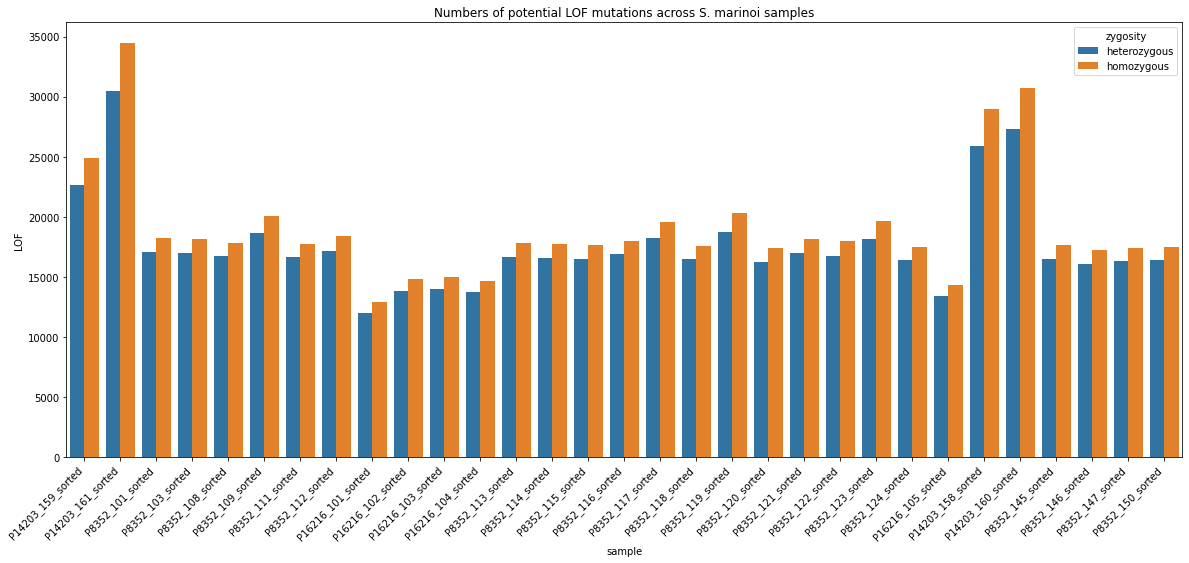

In [7]:
plt.figure(figsize=(20, 8))

plt_order = Control_2000_het_nb.columns.tolist() + Treated_2000_het_nb.columns.tolist() + Treated_1972_het_nb.columns.tolist()

p = sns.barplot(data=merged_nb_ann,
            x='sample', 
            y='LOF',
            hue='zygosity',
            estimator=sum, 
            ci=None,
            order=plt_order)
p.set_xticklabels(p.get_xticklabels(),rotation=45, ha="right")
p.set_title('Numbers of potential LOF mutations across S. marinoi samples');

#### Numbers of LOF mutations per group - swarmplot and significance tests

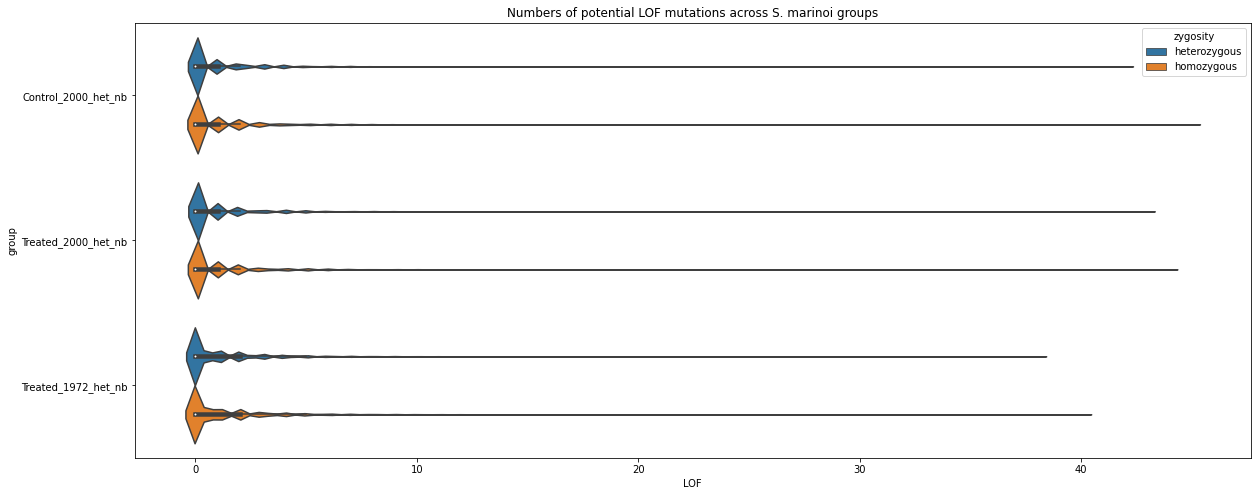

In [38]:
#https://seaborn.pydata.org/generated/seaborn.swarmplot.html
#add group to df

group_dict = {}

for i in Control_2000_het_nb.columns:
        group_dict[i] = "Control_2000_het_nb"
for i in Treated_2000_het_nb.columns:
        group_dict[i] = "Treated_2000_het_nb"
for i in Treated_1972_het_nb.columns:
        group_dict[i] = "Treated_1972_het_nb"

merged_nb_ann['group'] = merged_nb_ann['sample'].map(group_dict)
#merged_nb_ann

plt.figure(figsize=(20, 8))

s = sns.violinplot(data=merged_nb_ann,
            x="LOF", 
            y="group",
            hue="zygosity",
            orient="h",
            scale="count",
            showextrema=False)
            #inner="point")
#s.set_xticklabels(p.get_xticklabels(),rotation=45, ha="right")
s.set_title('Numbers of potential LOF mutations across S. marinoi groups');
#https://towardsdatascience.com/beautiful-boxplots-with-statistical-significance-annotation-e1b314927fc5
#    (but with swarmplots?)

#### Normalize numbers of LOF mutations per sample, by gene counts and length of each chromosome

In [ ]:
from Bio import SeqIO
from BCBio import GFF

merged_nb_ann_norm = merged_nb_ann.copy()

#chromosome length and gene count dictionary
big_chrom_dict = {}

for seq_record in SeqIO.parse("Smar_v1.1.2.fasta", "fasta"):
    #for each chromosome store chromosome length
    big_chrom_dict[seq_record.id] = [len(seq_record)]

in_file = "Sm_ManualCuration.v1.1.2.gff"

#open GFF file
in_handle = open(in_file)
for rec in GFF.parse(in_handle):
    #for each chromosome store gene count
    big_chrom_dict[rec.id].append(len(rec.features))
in_handle.close()

for index, row in merged_nb_ann_norm.iterrows():
    for key, value in big_chrom_dict.items():
        if row["chromosome"] == key:
            merged_nb_ann_norm.loc[index, "LOF_n_genec"] = (row["LOF"]/value[1])
            merged_nb_ann_norm.loc[index, "LOF_n_chroml"] = (row["LOF"]/value[0])
            break
merged_nb_ann_norm

#### Numbers of LOF mutations per sample, normalized by gene counts in each chromosome

In [ ]:
plt.figure(figsize=(20, 8))

plt_order = Control_2000_het_nb.columns.tolist() + Treated_2000_het_nb.columns.tolist() + Treated_1972_het_nb.columns.tolist()

p = sns.barplot(data=merged_nb_ann_norm,
            x='sample', 
            y='LOF_n_genec',
            hue='zygosity',
            estimator=sum, 
            ci=None,
            order=plt_order)
p.set_xticklabels(p.get_xticklabels(),rotation=45, ha="right")
p.set_title('Numbers of potential LOF mutations across S. marinoi samples, normalized by gene counts per chromosome');

#### Numbers of LOF mutations per sample, normalized by chromosome length

In [ ]:
plt.figure(figsize=(20, 8))

plt_order = Control_2000_het_nb.columns.tolist() + Treated_2000_het_nb.columns.tolist() + Treated_1972_het_nb.columns.tolist()

p = sns.barplot(data=merged_nb_ann_norm,
            x='sample', 
            y='LOF_n_chroml',
            hue='zygosity',
            estimator=sum, 
            ci=None,
            order=plt_order)
p.set_xticklabels(p.get_xticklabels(),rotation=45, ha="right")
p.set_title('Numbers of potential LOF mutations across S. marinoi samples, normalized by chromosome lengths');

#### Numbers of mutations per gene per sample

In [13]:
het_concat = pd.concat([Control_2000_het_nb, Treated_2000_het_nb, Treated_1972_het_nb], axis=1)
hom_concat = pd.concat([Control_2000_hom_nb, Treated_2000_hom_nb, Treated_1972_hom_nb], axis=1)

het_concat = het_concat[~het_concat.index.str.contains("Sm_plastid|Sm_mito")]
hom_concat = hom_concat[~hom_concat.index.str.contains("Sm_plastid|Sm_mito")]

het_concat['genes'] = het_concat.index
hom_concat['genes'] = hom_concat.index

#count_lofs() needs a 'genes' column, removed plastid and mito contigs
het_concat_out = count_lofs(het_concat)
hom_concat_out = count_lofs(hom_concat)

In [14]:
#added zygosity labels to each df so they can each be melted and merged
het_concat_out['zygosity'] = "heterozygous"
melt_het_concat_out = pd.melt(het_concat_out, id_vars=['samples','zygosity'], 
                              var_name="bins", 
                              value_name="LOF", ignore_index=False)
hom_concat_out['zygosity'] = "homozygous"
melt_hom_concat_out = pd.melt(hom_concat_out, id_vars=['samples','zygosity'], 
                              var_name="bins", 
                              value_name="LOF", ignore_index=False)

to_merge_out = [melt_het_concat_out, melt_hom_concat_out]

lofs_merged = pd.concat(to_merge_out)

unique_bins = lofs_merged.bins.unique()
sample_order = lofs_merged.samples.unique()

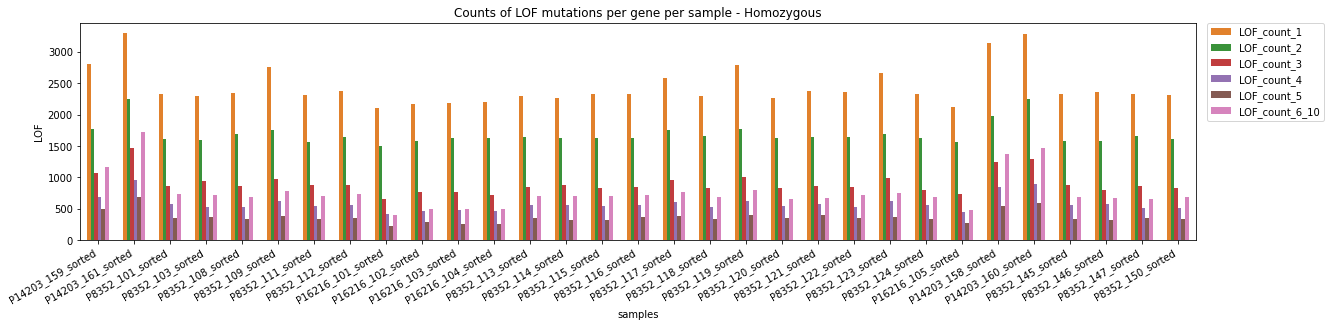

In [15]:
plt.figure(figsize=(20, 4))

o = sns.barplot(data=lofs_merged[(lofs_merged['zygosity'] == "homozygous") & (lofs_merged['bins'] != "LOF_count_0")],
                x="samples", 
                y="LOF",
                hue="bins",
                hue_order=unique_bins,
                palette="tab10",
                order=sample_order)

o.set_xticklabels(o.get_xticklabels(),rotation=30, ha="right")
o.set_title('Counts of LOF mutations per gene per sample - Homozygous');
h,l = o.get_legend_handles_labels()
plt.legend(h[1:7],l[1:7],bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

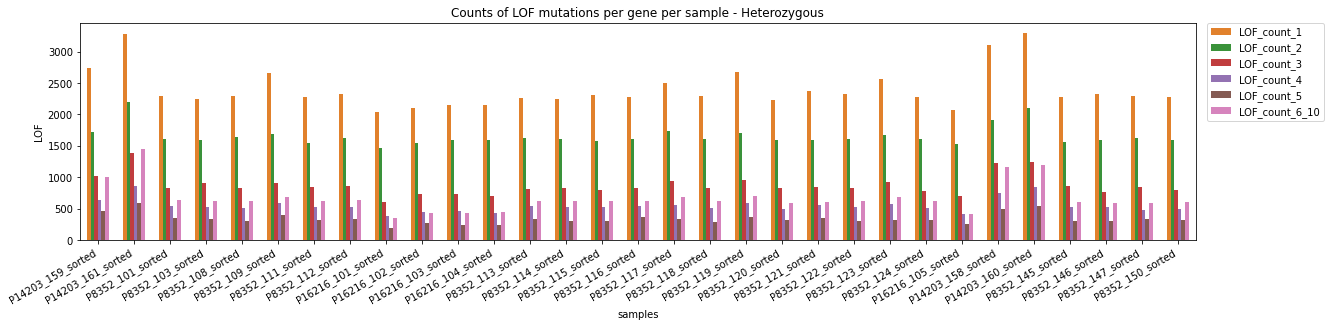

In [16]:
plt.figure(figsize=(20, 4))

r = sns.barplot(data=lofs_merged[(lofs_merged['zygosity'] == "heterozygous") & (lofs_merged['bins'] != "LOF_count_0")],
                x="samples", 
                y="LOF",
                hue="bins",
                hue_order=unique_bins,
                palette="tab10",
                order=sample_order)

r.set_xticklabels(o.get_xticklabels(),rotation=30, ha="right")
r.set_title('Counts of LOF mutations per gene per sample - Heterozygous');
h,l = r.get_legend_handles_labels()
plt.legend(h[1:7],l[1:7],bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

### 